## LISST GSD analysis

In [72]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.interpolate import interp1d

Import all raw files 

In [2]:
# directory where the CSV files are located
folder_path = "raw_samples"

# list all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# loop through each CSV file and read it into a DataFrame and create variables
for csv_file in csv_files:
    file_name = os.path.splitext(csv_file)[0]  # Get the file name without the extension
    file_path = os.path.join(folder_path, csv_file)
    # create a variable with the file name and store the DataFrame
    exec(f"{file_name} = pd.read_csv(file_path, encoding='latin1')")

Create new column of frequencies and cumulative distributions

In [17]:
for file_name in csv_files:
    df_name = file_name[:-4] # remove the '.csv' extension from the file name
    df = globals()[df_name] # get the df from the global variables
    total = df['Vol Conc'].iloc[-1] # get the total from the last row
    df['Frequency'] = np.round(df['Vol Conc'].div(total) * 10000000) # get the frequency and multiply by 10000 to get integer numbers
    df.loc[df.index[-1], 'Frequency'] = df['Frequency'][:-1].sum() # get the sum of the frequency and store it in the last row (this will be n)
    df['Percent'] = df['Vol Conc'].div(total) # get the percent from 0 to 1
    df ['Cumulative %'] = df['Percent'].cumsum() # get the cumulative percent
    globals()[df_name] = df # update the df in the global variables

Create a DataFrame with random sizes (samples!!!!!!!)

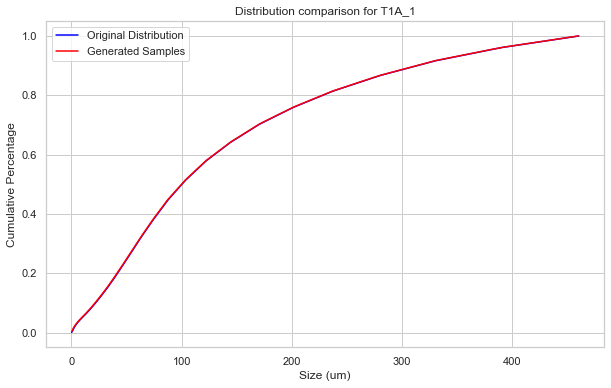

In [139]:
# generate random samples based on the cumulative distribution
def generate_random_samples(size, cumulative_percentage, num_samples):
    u = np.random.rand(num_samples)
    samples = np.interp(u, cumulative_percentage, size)
    return samples

num_samples = 10000000 # number of random samples to generate
samples = pd.DataFrame() # create an empty DataFrame to store the samples

for file_name in csv_files:
    df_name = file_name[:-4]  # Remove the '.csv' extension from the file name
    df = globals()[df_name]  # Get the DataFrame from the global variables
    
    # Convert 'Size (um)' column to numeric
    sizes = pd.to_numeric(df.iloc[:-1, 0].values, errors='coerce')
    cumulative_percentage = df['Cumulative %'].iloc[:-1].astype(float).values
    
    # Make sure not to repeat the last row
    random_samples = generate_random_samples(sizes, cumulative_percentage, num_samples)
    samples[df_name] = pd.Series(random_samples)


# As example, plot the original distribution and the generated samples of T1A_1
# calculate the cumulative distribution of the generated samples
hist, edges = np.histogram(samples['T1A_1'], bins=1000, density=True)
random_cumulative_distribution = np.cumsum(hist * np.diff(edges))

# plot the original distribution
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
plt.plot(sizes, T1A_1['Cumulative %'].iloc[:-1].values, label='Original Distribution', color='blue')
# plot the cumulative distribution of the generated samples
plt.plot(edges[:-1], random_cumulative_distribution, label='Generated Samples', color='red')

# set plot labels and title
plt.xlabel('Size (um)')
plt.ylabel('Cumulative Percentage')
plt.title('Distribution comparison for T1A_1')
plt.legend()

plt.show()

Checking the distributions!! 

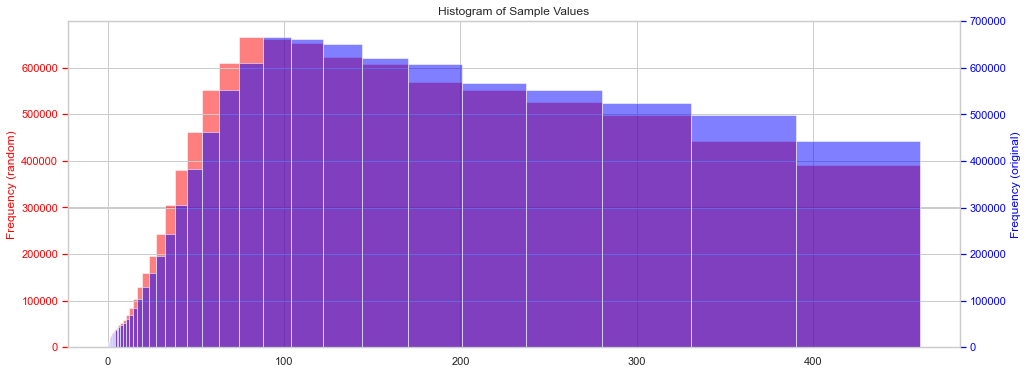

In [140]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot the first histogram on ax1
ax1.hist(samples['T1A_1'], bins=sizes, alpha=0.5, label='random', color='red')
ax1.set_ylabel('Frequency (random)', color='red')
ax1.tick_params('y', colors='red')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.hist(sizes[:-1], weights=T1A_1['Frequency'].iloc[:-2], bins=sizes, alpha=0.5, label='original', color='blue')
ax2.set_ylabel('Frequency (original)', color='blue')
ax2.tick_params('y', colors='blue')

plt.xlabel('Value')
plt.title('Histogram of Sample Values')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

### Are the replicates really similar? 

In [153]:
# Perform the Kolmogorov-Smirnov test
statistic, p_value = stats.ks_2samp(samples['T8D_1'], samples['T8D_2'])

# Print the results
print(f"KS Statistic: {statistic}")
print(f"P-value: {p_value:.15f}")

# Interpret the results
if p_value < 0.05:
    print("The two samples are likely from different distributions.")
else:
    print("There is not enough evidence to suggest that the two samples are from different distributions.")

KS Statistic: 0.0733511
P-value: 0.000000000000000
The two samples are likely from different distributions.


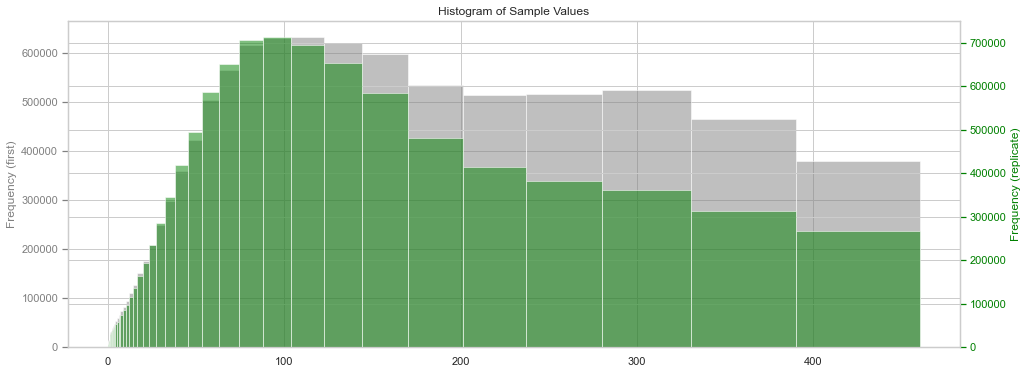

In [145]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot the first histogram on ax1
ax1.hist(samples['T8D_1'], bins=sizes, alpha=0.5, label='first', color='gray')
ax1.set_ylabel('Frequency (first)', color='gray')
ax1.tick_params('y', colors='gray')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.hist(samples['T8D_2'], bins=sizes, alpha=0.5, label='replicate', color='green')
ax2.set_ylabel('Frequency (replicate)', color='green')
ax2.tick_params('y', colors='green')

plt.xlabel('Value')
plt.title('Histogram of Sample Values')
plt.xticks(rotation=45)  # Rotate x-axis labels
plt.show()

### KW TEST!! 

For Probe 1

In [157]:
# Perform Kruskal-Wallis test
stat, p_value = stats.kruskal(samples['T1A_1'], samples['T1B_1'], samples['T1C_1'], samples['T1D_1']) 

print(f"Kruskal-Wallis Statistic: {stat}")
print(f"P-value: {p_value:.45f}")

Kruskal-Wallis Statistic: 640227.7189624708
P-value: 0.000000000000000


For Probe 2

In [158]:
# Perform Kruskal-Wallis test
stat, p_value = stats.kruskal(samples['T2A_1'], samples['T2B_1'])

print(f"Kruskal-Wallis Statistic: {stat}")
print(f"P-value: {p_value:.45f}")

Kruskal-Wallis Statistic: 103508.55539978582
P-value: 0.000000000000000000000000000000000000000000000


For Probe 3

In [159]:
# Perform Kruskal-Wallis test
stat, p_value = stats.kruskal(samples['T3C_1'], samples['T3D_1']) 

print(f"Kruskal-Wallis Statistic: {stat}")
print(f"P-value: {p_value:.45f}")

Kruskal-Wallis Statistic: 195.77421536373123
P-value: 0.000000000000000000000000000000000000000000017


For Probe 5

In [160]:
# Perform Kruskal-Wallis test
stat, p_value = stats.kruskal(samples['T5A_1'], samples['T5B_1'], samples['T5C_1'], samples['T5D_1']) 

print(f"Kruskal-Wallis Statistic: {stat}")
print(f"P-value: {p_value:.45f}")

Kruskal-Wallis Statistic: 770677.8296305003
P-value: 0.000000000000000000000000000000000000000000000


For Probe 6

In [161]:
# Perform Kruskal-Wallis test
stat, p_value = stats.kruskal(samples['T6A_1'], samples['T6B_1'], samples['T6C_1'], samples['T6D_1']) 

print(f"Kruskal-Wallis Statistic: {stat}")
print(f"P-value: {p_value:.45f}")

Kruskal-Wallis Statistic: 1114381.9227481077
P-value: 0.000000000000000000000000000000000000000000000


For Probe 7

In [162]:
# Perform Kruskal-Wallis test
stat, p_value = stats.kruskal(samples['T7A_1'], samples['T7B_1'], samples['T7C_1'], samples['T7D_1']) 

print(f"Kruskal-Wallis Statistic: {stat}")
print(f"P-value: {p_value:.45f}")

Kruskal-Wallis Statistic: 149813.4390848572
P-value: 0.000000000000000000000000000000000000000000000


For Probe 8

In [163]:
# Perform Kruskal-Wallis test
stat, p_value = stats.kruskal(samples['T8A_1'], samples['T8C_1']) 

print(f"Kruskal-Wallis Statistic: {stat}")
print(f"P-value: {p_value:.45f}")

Kruskal-Wallis Statistic: 162004.0600984517
P-value: 0.000000000000000000000000000000000000000000000
